# Turning point analysis
- Work flow
    1. turn tick data into daily data
        - findataflow
    1. For each maturity
        - detect turing points (N)
            - N = 1, 2, 3, ...
        - combine turning points
    1. summarize turning points by day-to-maturity
        - frequency
        - slope
        - duration
        - optimal lambda


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# pretty print for consecutive dfs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime
import seaborn as sns

## pararmeter

In [4]:
N = 1

## turn tick data into daily data

In [5]:
import config as cfg

def get_maturity(series_date):
    settlements = pd.to_datetime(pd.read_csv(cfg.PATH_SETTLEMENTS).settlement).dt.date
    maturities = series_date.where(series_date.isin(settlements)).fillna(method='bfill')
    maturities.where(maturities >= settlements.min(), inplace = True)
    return maturities


In [6]:
from findataflow.dataprocs import resample

In [7]:
df_ohlc = resample.get_OHLCV_given_frequency(symbol='TXF', freq='1D')
df_ohlc.reset_index(inplace=True)
df_ohlc.rename(columns={'index': 'tx_datetime'}, inplace=True)
df_ohlc['tx_datetime'] = df_ohlc.tx_datetime.dt.date
df_ohlc.loc[df_ohlc.shape[0]] = [datetime.date(2014,3,19), 8734, 8742, 8684, 8696, np.nan]#TODO: no data
df_ohlc.sort_values('tx_datetime', inplace=True)
df_ohlc['maturity'] = get_maturity(df_ohlc.tx_datetime)
df_ohlc['day_to_maturity'] = (df_ohlc.tx_datetime - df_ohlc.maturity).dt.days
df_ohlc.head();

transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV


In [8]:
df_ohlc.tail();

## turing point at maturity-level
- detect turing points (N)
    - N = 1, 2, 3, ...
- combine turning points

In [9]:
def get_marked_turnpt(prc_ohlc, N): 
    assert 'tx_datetime' in prc_ohlc.columns, 'tx_datetime is not in column name list'
    assert 'low' in prc_ohlc.columns, 'low is not in column name list'
    assert 'high' in prc_ohlc.columns, 'high is not in column name list'
    
    df_prc = prc_ohlc[['tx_datetime']].copy()
    window = prc_ohlc[['close']].rolling(window=2*N+1, center=True, min_periods=(N+1)+1)
    df_prc['N'] = N
    df_prc['is_turnpt_upward'] = (prc_ohlc.close == window.min().close).astype(int)
    df_prc['is_turnpt_downward'] = (prc_ohlc.close == window.max().close).astype(int)
    df_prc['is_turnpt'] = df_prc.is_turnpt_upward + df_prc.is_turnpt_downward * (-1)
    return df_prc

def get_combined_turnpt(df_turnpt_ohlc):
    def get_extreme(df_same):
        direction = df_same.is_turnpt.unique()
        assert len(direction) == 1, 'should be only 1 direction'
        direction = direction[0]
        if direction == 1:
            idx_candidate = df_same.close.values.argmin()
        elif direction == -1:
            idx_candidate = df_same.close.values.argmax()
        df_extreme = df_same.iloc[[idx_candidate]]
        return df_extreme
    
    df = df_turnpt_ohlc.query('is_turnpt != 0').reset_index(drop=True)
    df['same_direction'] = np.where((df.is_turnpt * df.is_turnpt.shift(1)) == -1, 1, 0).cumsum()
    df_turnpt_combined = df.groupby('same_direction', as_index=False).apply(get_extreme).reset_index(drop=True)
    
    common_columns = ['tx_datetime', 'N']
    df_turnpt_combined = df_turnpt_combined[common_columns+['is_turnpt_upward', 'is_turnpt_downward', 'is_turnpt']]
    df_turnpt_ohlc = df_turnpt_ohlc[common_columns + [col for col in df_turnpt_ohlc.columns if col not in df_turnpt_combined.columns]]
    df_turnpt_ohlc_combined = df_turnpt_ohlc.merge(df_turnpt_combined, on=common_columns, how='left')
    return df_turnpt_ohlc_combined

def plot_turnpt(df_turnpt_ohlc, N):
    df_plot = df_turnpt_ohlc.copy()
    df_plot.set_index('tx_datetime', inplace=True)
    def find_loc(df, dates):
        return [df.index.get_loc(date) for date in dates]
    
    dates_upward = df_plot.query(f'(N == {N}) and (is_turnpt_upward==1)').index
    df_plot.close.plot.line(figsize=(20, 5), color='white', markevery=find_loc(df_plot, dates_upward), marker='^', markerfacecolor='red', markeredgewidth=0.0)

    dates_downward = df_plot.query(f'(N == {N}) and (is_turnpt_downward==1)').index
    df_plot.close.plot.line(figsize=(20, 5), color='black', markevery=find_loc(df_plot, dates_downward), marker='v', markerfacecolor='green', markeredgewidth=0.0)
    plt.title(f'N: {N}')
    
def get_prc_diff(dt_start, dt_end):
    if dt_end is np.nan:
        return np.nan
    prc_start = df_ohlc[df_ohlc.tx_datetime.isin([dt_start])].close.values[0]
    prc_end = df_ohlc[df_ohlc.tx_datetime.isin([dt_end])].close.values[0]
    prc_diff = prc_end - prc_start
    return prc_diff

def get_turnpt_magnitude(df_turnpt_ohlc_combined, N):
    idx_columns = ['tx_datetime', 'maturity']

    df_m = df_turnpt_ohlc_combined.query(f'(N == {N}) and (is_turnpt != 0)')[idx_columns].copy()
    df_m['next_dt_turnpt'] = df_m.tx_datetime.shift(-1).fillna(df_m.tx_datetime.max())#.fillna(df_m.maturity.max())
    df_m['prc_diff'] = df_m.apply(lambda x: get_prc_diff(x.tx_datetime, x.next_dt_turnpt), axis=1)
    df_m['duration'] = (df_m.next_dt_turnpt - df_m.tx_datetime).dt.days
    df_m['slope'] = df_m.prc_diff.div(df_m.duration)
    df_m = df_turnpt_ohlc_combined.merge(df_m, on = idx_columns, how= 'left')    
    return df_m

In [10]:
df_turnpt = df_ohlc.groupby('maturity', as_index=False).apply(lambda x: get_marked_turnpt(x, N))
df_turnpt_ohlc =  df_turnpt.merge(df_ohlc, on='tx_datetime', how='left')
df_turnpt_ohlc_combined = df_turnpt_ohlc.groupby('maturity', as_index=False).apply(get_combined_turnpt)

In [11]:
df_turnpt_measures = df_turnpt_ohlc_combined.groupby('maturity', as_index=False).apply(lambda x: get_turnpt_magnitude(x, N))

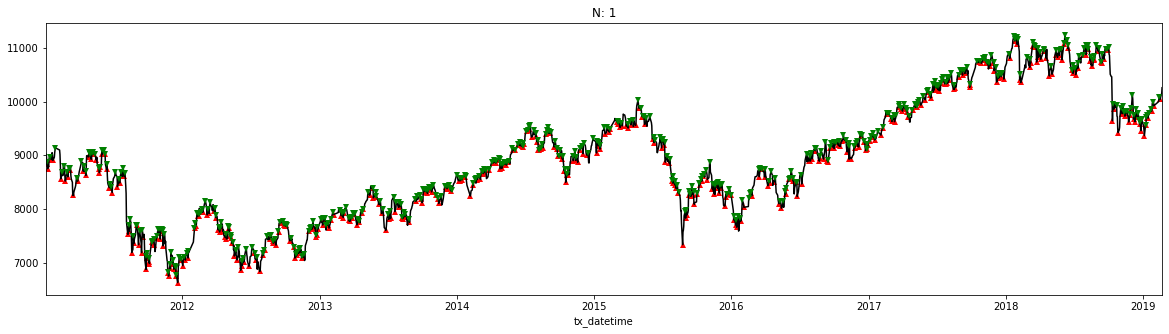

In [12]:
plot_turnpt(df_turnpt_measures, N)

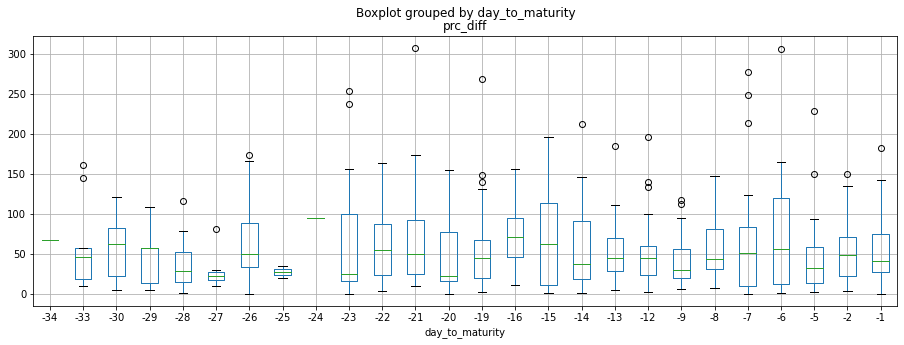

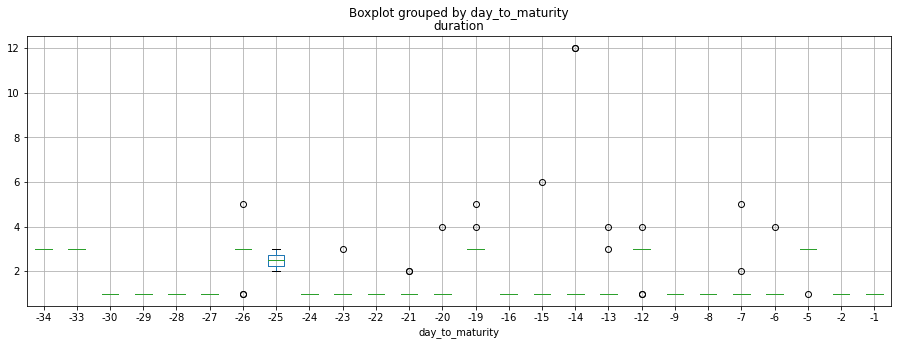

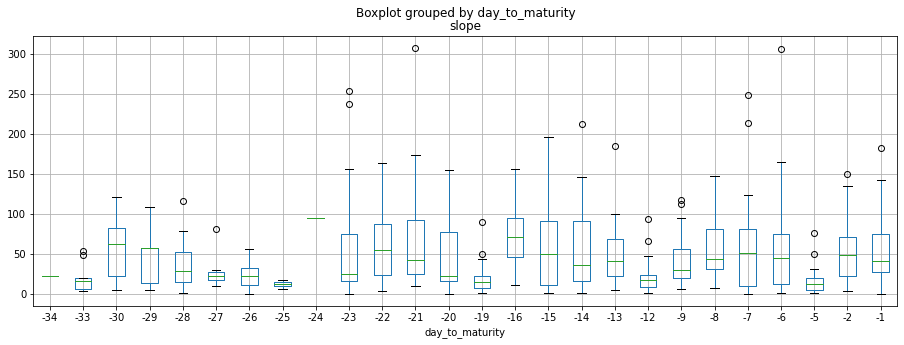

In [13]:
# upward
df_plot_turn_upward = df_turnpt_measures.query('is_turnpt_upward == 1')
assert (df_plot_turn_upward.prc_diff < 0).sum() == 0, 'all prc diff must be greater than zero'
df_plot_turn_upward.boxplot('prc_diff', by = 'day_to_maturity', figsize = (15, 5))
df_plot_turn_upward.boxplot('duration', by = 'day_to_maturity', figsize = (15, 5))
df_plot_turn_upward.boxplot('slope', by = 'day_to_maturity', figsize = (15, 5))

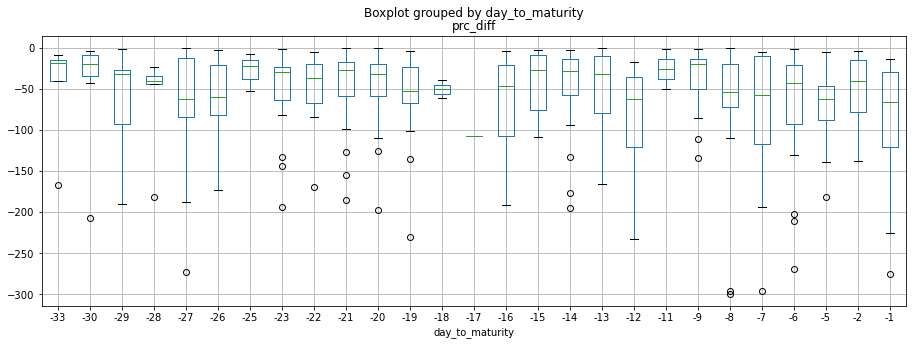

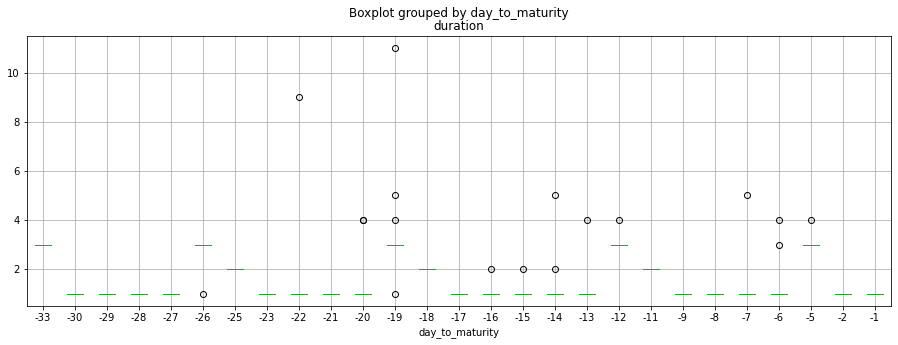

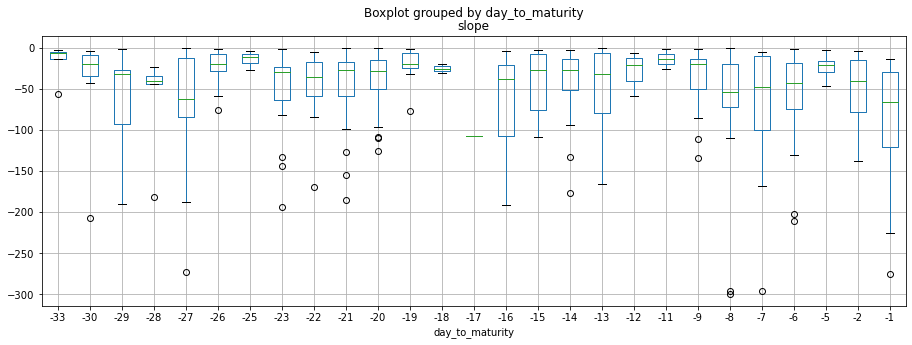

In [14]:
# downward
df_plot_turn_downward = df_turnpt_measures.query('is_turnpt_downward == 1')
assert (df_plot_turn_downward.prc_diff > 0).sum() == 0, 'all prc diff must be smaller than zero'
df_plot_turn_downward.boxplot('prc_diff', by = 'day_to_maturity', figsize = (15, 5))
df_plot_turn_downward.boxplot('duration', by = 'day_to_maturity', figsize = (15, 5))
df_plot_turn_downward.boxplot('slope', by = 'day_to_maturity', figsize = (15, 5))

In [15]:
def analysis(df):
    df = df.query('turn == 1').copy()
    df_res = pd.DataFrame(index=[0])
    df_res['n_turn'] = df.shape[0]
    df_res['prc_diff'] = df.prc_diff.mean()
    df_res['duration'] = df.duration.mean()
    df_res['slope'] = df.slope.mean()
    return df_res
df_analysis = pd.melt(df_turnpt_measures, id_vars=[col for col in df_turnpt_measures.columns if col not in ['is_turnpt_upward', 'is_turnpt_downward']], var_name = 'direction', value_name='turn')
idx_columns = ['N', 'direction', 'day_to_maturity']
df_summary = df_analysis.groupby(idx_columns).apply(analysis).reset_index(idx_columns)

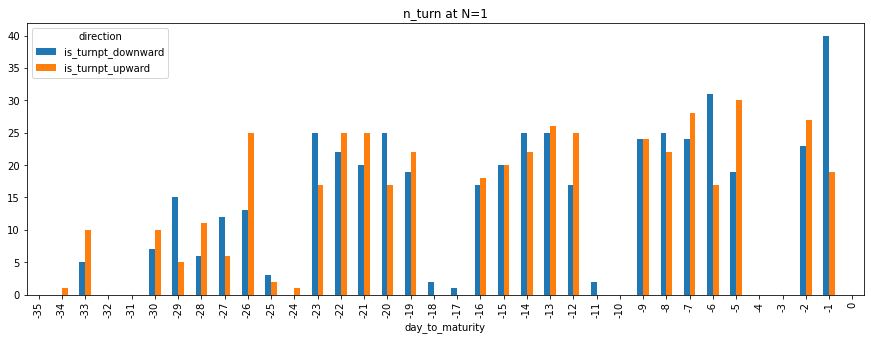

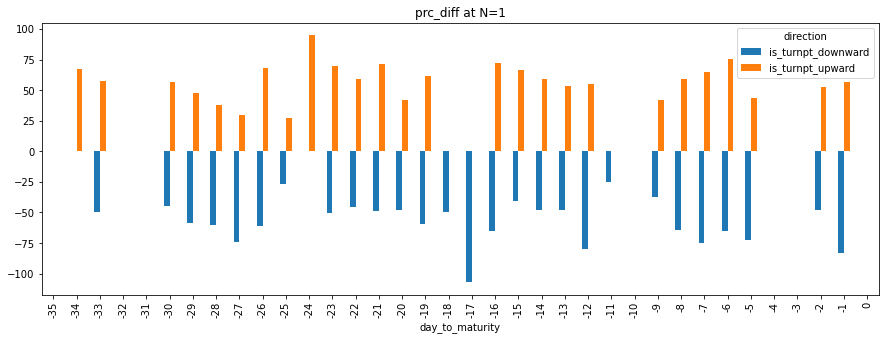

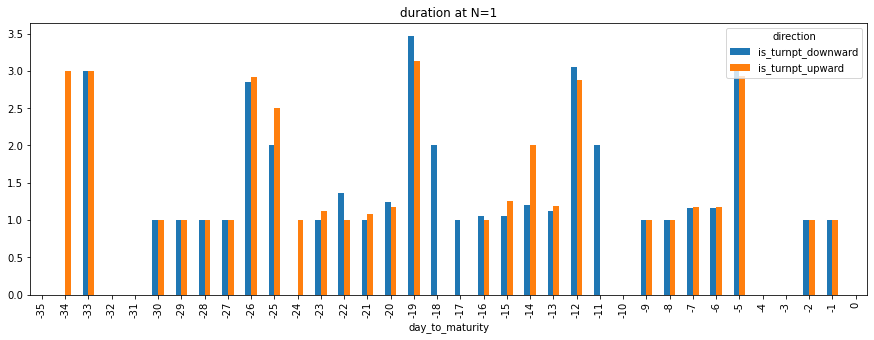

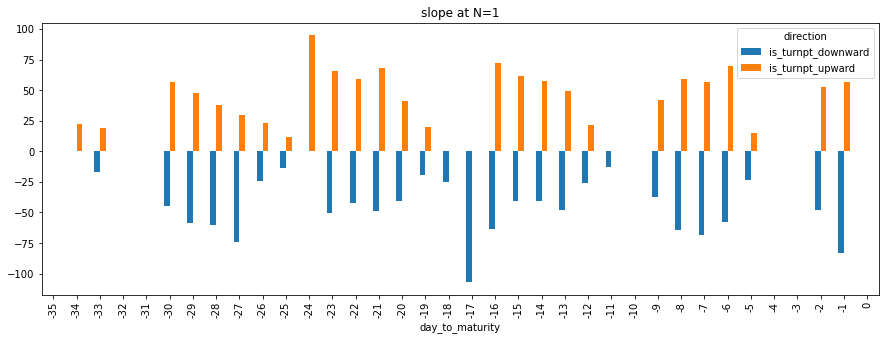

In [16]:
for col in df_summary.columns:
    if col in idx_columns:
        continue
    df_summary.set_index(['direction', 'day_to_maturity'])[col].unstack('direction').plot.bar(figsize=(15, 5), title=f'{col} at N={N}')

# which N is the best?
- check trading opportunity